# inicialização

In [1]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
import scipy.signal as signal
from sympy import symbols, pprint
import matplotlib.pyplot as plt
from structureSelector import *
from methods.utils.utilities import *
import plotly.express as px

J = 4.948e-6   #kgm²
R = 0.0132  #m
m = 0.071   #kg
g = 9.81    #m/s^2
r = 0.0118  #m
h = 0.035   #m

fb = 0.0362 #N*d/m
vt = 0.008  #m/s
a0 = -0.16  #deg

a = (J/(r**2) + m)

a1 = - m * (h+r) / a
a2 = -(J/r) / a
a3 = m * g / a
a4 = m / a

# Parâmetros do servo motor DC (valores típicos)
J = 0.01    # Momento de inércia (kg.m^2)
B = 0.1     # Coeficiente de atrito viscoso (N.m.s)
K_t = 0.01  # Constante de torque (N.m/A)
K_e = 0.01  # Constante de força contra-eletromotriz (V/rad/s)
R = 1       # Resistência do enrolamento (ohms)
L = 0.5     # Indutância do enrolamento (H)

# Função de transferência do servo motor DC
num = [K_t]
den = [(J*L), (J*R + B*L), (B*R + K_t*K_e)]

servo_system = signal.TransferFunction(num, den)


# estimação

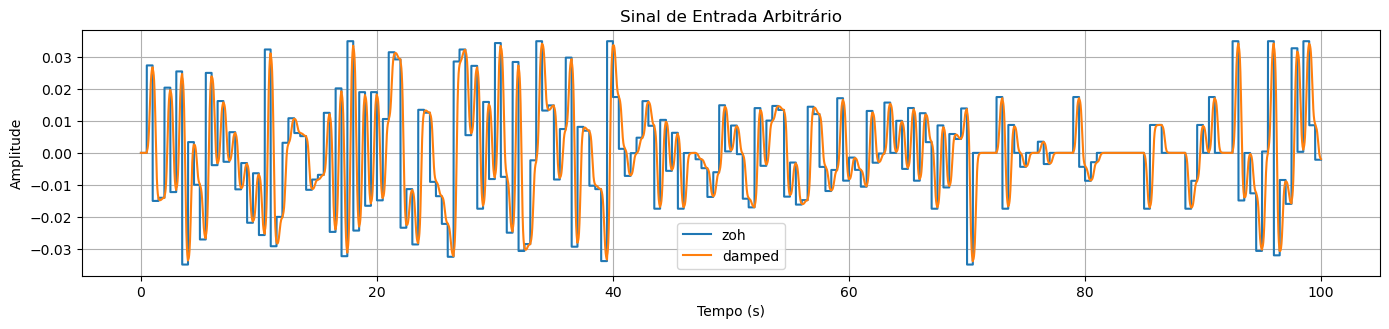

In [146]:
dt = 0.01
size = 100
step = 0.5
div = int(size // step)
t = np.arange(0, size, dt)
stairs = np.zeros(t.shape)
un = np.zeros(t.shape)
np.random.seed(48)
urange = 0.017453293 * 2
l1 = 80
l2 = 140
mag = np.random.uniform(-urange, urange, div)
rt = int(t.shape[0] / div)
curve = 1/(1+np.exp(-16*t+4))

mag[0] = 0
mag[7] = -2 * 0.017453293 
mag[11] = -mag[11]
mag[21] = -mag[21]
mag[35] = 2 * 0.017453293 
mag[49], mag[53] = mag[53], mag[49]
mag[57] = -1 * 0.017453293
mag[67] = 2 * 0.017453293
mag[69], mag[70] = mag[70], mag[69]

mag[l1:l2] = np.random.uniform(-urange/2, urange/2, l2 - l1)

mag[l1-1] = urange
mag[l1] = urange/2
mag[87] = -urange/2
mag[91] = -urange/2
mag[127] = 0
mag[134] = -urange/2

mag[140:] = 0
mag[140] = -urange
mag[145] = urange/2
mag[146] = -urange/2
mag[147] = urange/4
mag[149] = -urange/8
mag[152] = urange/10
mag[153] = -urange/10

mag[158] = urange/2
mag[159] = -urange/8
mag[160] = -urange/4
mag[161] = -urange/12

mag[170] = -urange/2
mag[171:173] = urange/4
mag[177] = -urange/2
mag[178] = -urange/4
mag[179] = urange/4
mag[181] = urange/2

mag[185] = urange
mag[186:] = np.random.uniform(-urange, urange, 14)
mag[191] = urange
mag[197] = urange

for i in range(1, div):
    stairs[rt*i:rt*(i+1)] = mag[i]
    un[rt*i:] += (mag[i] - mag[i-1]) * curve[:curve.shape[0]-rt*i]

plt.figure(figsize=(14, 6));plt.subplot(2, 1, 1)
plt.plot(t, stairs, label="zoh");plt.plot(t, un, label="damped")
plt.title("Sinal de Entrada Arbitrário");plt.xlabel("Tempo (s)");plt.ylabel("Amplitude")
plt.grid(True);plt.legend();plt.tight_layout();plt.show()

## simul

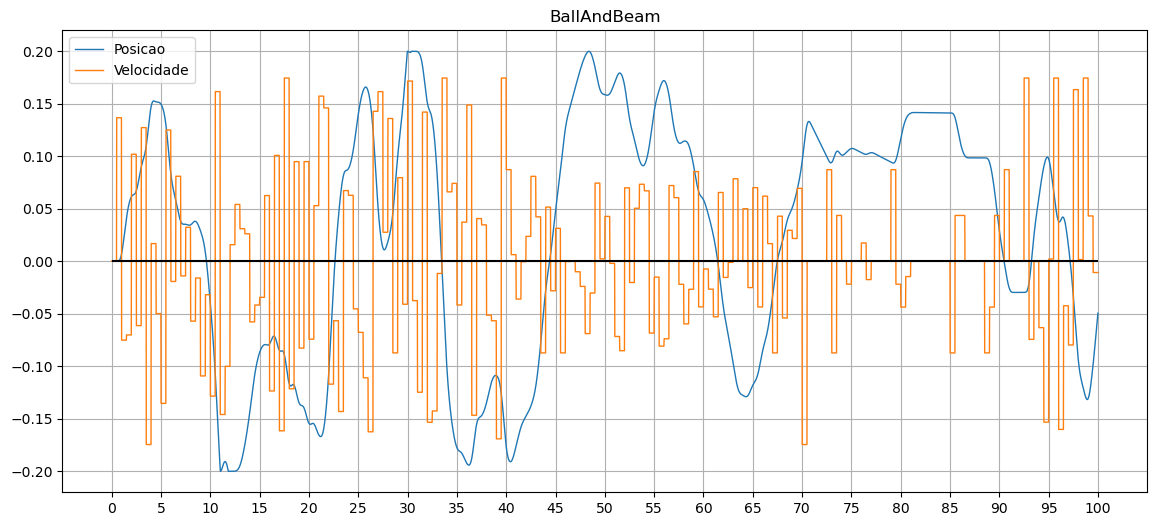

In [147]:
u = un.copy();du = np.zeros(t.shape);d2u = np.zeros(t.shape)

du[1:] = (u[1:] - u[:-1]) / dt;d2u[2:] = (du[2:] - du[1:-1]) / dt

s = np.zeros(t.shape);ds = np.zeros(t.shape);d2s = np.zeros(t.shape)

for i in range(1, t.shape[0]):
    um = (u[i-1] + u[i]) / 2
    dum = (um - u[i-1]) / dt
    k1 = m * s[i-1] * (du[i-1]**2) / a + m * g * np.sin(u[i-1]) / a
    k2 = m * (s[i-1] + (dt/2) * k1) * (dum**2) / a + m * g * np.sin(um) / a
    k3 = m * (s[i-1] + (dt/2) * k2) * (dum**2) / a + m * g * np.sin(um) / a
    k4 = m * (s[i-1] + dt * k3) * (du[i]**2) / a + m * g * np.sin(u[i]) / a

    ds[i] = ds[i-1] + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
    s[i] = np.clip(s[i-1] + ds[i] * dt, -0.2, 0.20)
    if np.abs(s[i]) >= 0.2:
        ds[i] = 0
        
begin = int(0 * 1e+2)
end = int(100 * 1e+2)
plt.figure(figsize=(14, 6))
plt.title("BallAndBeam")
plt.plot(t[begin:end], s[begin:end], linewidth=1, label="Posicao")
plt.plot(t[begin:end], stairs[begin:end] * 5, linewidth=1, label="Velocidade")
plt.hlines(0, begin // 100, end // 100, colors='black')
plt.xticks(np.arange(begin // 100, end // 100 + 1, 5))
plt.legend();plt.grid();plt.show()

In [290]:
data = np.vstack((un[::1], s[::1], ds[::1], t[::1])).T
print(un.shape, s.shape, data.shape)
np.savetxt("data/ballBeamSaturado.csv", data, delimiter=",", fmt="%.6f", header="input,output,derivada,time", comments="")

(10000,) (10000,) (10000, 4)


# estimação 2

In [159]:
dt = 0.01
size = 100
step = 0.5
div = int(size // step)
t = np.arange(0, size, dt)
stairs = np.zeros(t.shape)
un = np.zeros(t.shape)
np.random.seed(48)
urange = 0.017453293 * 2
l1 = 80
l2 = 140
mag = np.random.uniform(-urange, urange, div)
rt = int(t.shape[0] / div)
curve = 1/(1+np.exp(-16*t+4))

mag[0] = 0
mag[7] = -2 * 0.017453293 
#mag[10] = 0.017453293*2
mag[11] = -mag[11]
mag[24] =  0.017453293 * 2
mag[20] = -mag[20]
mag[21] = -mag[21]
mag[35] = 2 * 0.017453293 

mag[43] = 1 * 0.017453293 
mag[44] = -2 * 0.017453293 
mag[49], mag[53] = mag[53], mag[49]
mag[57] = -1 * 0.017453293
mag[68] = 0.017453293 * 1.9
mag[69], mag[70] = mag[70], mag[69]

mag[l1:l2] = np.random.uniform(-urange/2, urange/2, l2 - l1)

mag[l1-1] = urange
mag[l1] = urange/2
mag[87] = -urange/2
mag[91] = -urange/2
mag[112] = urange/2
mag[124] = -urange/2

mag[134] = -urange/2
mag[136] = -urange * 0.5

mag[140:] = 0
mag[140] = -urange/2
mag[145] = -urange/8
mag[146] = -urange/4
mag[150] = urange/8
mag[151] = urange/6
mag[152] = urange/4


mag[185] = urange
mag[186:] = np.random.uniform(-urange, urange, 14)
mag[191] = urange
mag[197] = urange

for i in range(1, div):
    stairs[rt*i:rt*(i+1)] = mag[i]
    un[rt*i:] += (mag[i] - mag[i-1]) * curve[:curve.shape[0]-rt*i]
'''
plt.figure(figsize=(14, 6));plt.subplot(2, 1, 1)
plt.plot(t, stairs, label="zoh");plt.plot(t, un, label="damped")
plt.title("Sinal de Entrada Arbitrário");plt.xlabel("Tempo (s)");plt.ylabel("Amplitude")
plt.grid(True);plt.legend();plt.tight_layout();plt.show()'''

'\nplt.figure(figsize=(14, 6));plt.subplot(2, 1, 1)\nplt.plot(t, stairs, label="zoh");plt.plot(t, un, label="damped")\nplt.title("Sinal de Entrada Arbitrário");plt.xlabel("Tempo (s)");plt.ylabel("Amplitude")\nplt.grid(True);plt.legend();plt.tight_layout();plt.show()'

## simul

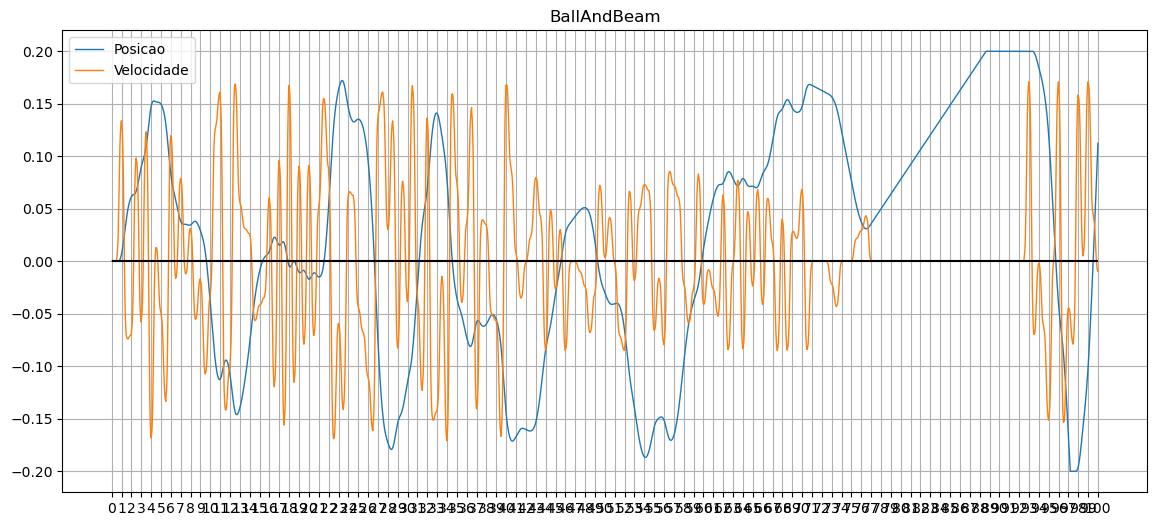

In [160]:
u = un.copy();du = np.zeros(t.shape);d2u = np.zeros(t.shape)

du[1:] = (u[1:] - u[:-1]) / dt;d2u[2:] = (du[2:] - du[1:-1]) / dt

s = np.zeros(t.shape);ds = np.zeros(t.shape);d2s = np.zeros(t.shape)

for i in range(1, t.shape[0]):
    um = (u[i-1] + u[i]) / 2
    dum = (um - u[i-1]) / dt
    k1 = m * s[i-1] * (du[i-1]**2) / a + m * g * np.sin(u[i-1]) / a
    k2 = m * (s[i-1] + (dt/2) * k1) * (dum**2) / a + m * g * np.sin(um) / a
    k3 = m * (s[i-1] + (dt/2) * k2) * (dum**2) / a + m * g * np.sin(um) / a
    k4 = m * (s[i-1] + dt * k3) * (du[i]**2) / a + m * g * np.sin(u[i]) / a

    ds[i] = ds[i-1] + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
    s[i] = np.clip(s[i-1] + ds[i] * dt, -0.2, 0.20)
    if np.abs(s[i]) >= 0.2:
        ds[i] = 0
        
begin = int(0 * 1e+2)
end = int(100 * 1e+2)
plt.figure(figsize=(14, 6))
plt.title("BallAndBeam")
plt.plot(t[begin:end], s[begin:end], linewidth=1, label="Posicao")
plt.plot(t[begin:end], u[begin:end] * 5, linewidth=1, label="Velocidade")
plt.hlines(0, begin // 100, end // 100, colors='black')
plt.xticks(np.arange(begin // 100, end // 100 + 1, 1))
plt.legend();plt.grid();plt.show()

In [ ]:
data = np.vstack((un[::1], s[::1], ds[::1], t[::1])).T
print(un.shape, s.shape, data.shape)
np.savetxt("data/ballBeamSaturado2.csv", data, delimiter=",", fmt="%.6f", header="input,output,derivada,time", comments="")

(10000,) (10000,) (10000, 4)


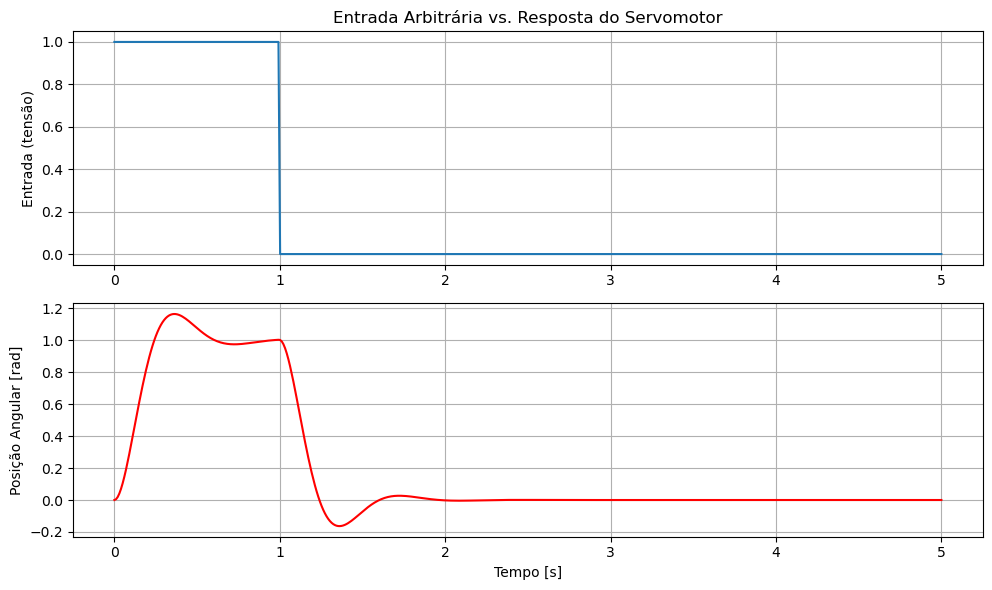

In [174]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import TransferFunction, lsim

# Parâmetros do servomotor
K = 1.0  # Constante eletromecânica
J = 0.01  # Momento de inércia
B = 0.1   # Coeficiente de atrito viscoso
R = 1.0   # Resistência do enrolamento
L = 0.0   # Indutância do enrolamento (desconsiderada para simplificação)

# Função de transferência da posição angular: θ(s) / V(s)
numerator = [K]
denominator = [J, B, K**2]

# Criando a função de transferência
system = TransferFunction(numerator, denominator)

# Gerando o tempo
t = np.linspace(0, 5, 500)

# Definindo uma entrada arbitrária (por exemplo, uma senóide)
u = np.zeros(t.shape)  # Sinal senoidal de amplitude 2 e frequência 0.5 Hz
u[:100] = 1
#u[100:150] = -10
# Calculando a resposta ao sinal arbitrário
t, response, _ = lsim(system, U=u, T=t)

# Plotando a entrada e a resposta
plt.figure(figsize=(10, 6))

# Entrada
plt.subplot(2, 1, 1)
plt.plot(t, u, label='Entrada Arbitrária (senóide)')
plt.title('Entrada Arbitrária vs. Resposta do Servomotor')
plt.ylabel('Entrada (tensão)')
plt.grid(True)

# Resposta
plt.subplot(2, 1, 2)
plt.plot(t, response, label='Resposta do Servomotor', color='r')
plt.xlabel('Tempo [s]')
plt.ylabel('Posição Angular [rad]')
plt.grid(True)

plt.tight_layout()
plt.show()


# Validação

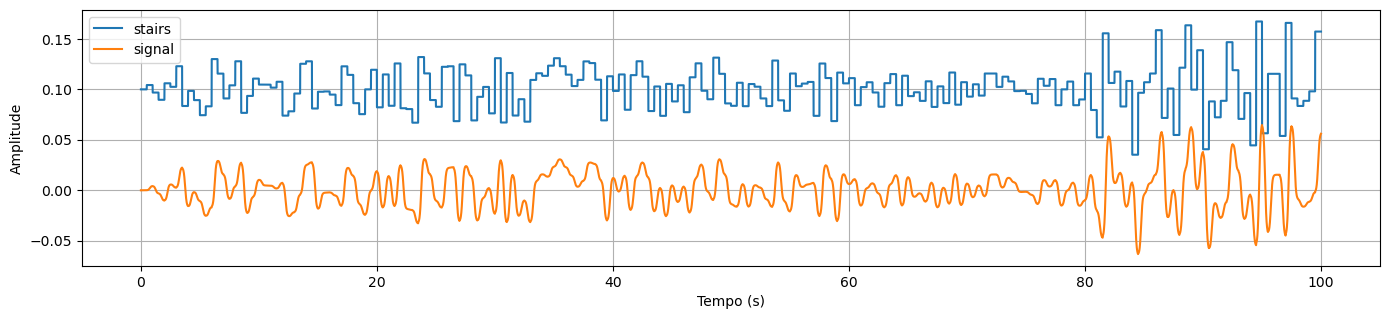

In [8]:
dt = 0.01
size = 100
step = 0.5
div = int(size // step)
t = np.arange(0, size, dt)
stairsVal = np.zeros(t.shape)
uVal = np.zeros(t.shape)
np.random.seed(53)
urange = 0.035
mag = np.random.uniform(-urange, urange, div)
rt = int(t.shape[0] / div)
curve = 1/(1+np.exp(-16*t+4))

mag[0] = 0
mag[12] = 0.03
mag[13] = 0.0156
mag[33] = -0.0156
mag[38] = 0
mag[47] = 0.032
mag[88] = -mag[88]#-0.0235
mag[110] = 0.0157

mag[120:160] = np.random.uniform(-urange/2, urange/2, 40)
mag[121] = -0.0157
mag[128] = -0.0157
mag[143] = 0.0157
mag[144] = 0.0157

mag[155] = -0.0157
mag[156] = 0.0
mag[158] = -0.0157
mag[159] = -0.01

#mag[160:] = 0.0
mag[160:] = np.random.uniform(-urange*2, urange*2, 40)
mag[160] = 0.0157
mag[171] = 0.0157
mag[172] = -mag[172]
#mag[179] = -0.0157
mag[184:186] = -mag[184:186]
mag[191] = mag[192]
mag[199] = -mag[199]

for i in range(1, div):
    stairsVal[rt*i:rt*(i+1)] = mag[i]
    uVal[rt*i:] += (mag[i] - mag[i-1]) * curve[:curve.shape[0]-rt*i]

plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
#plt.plot(t, curve, label="e")
plt.plot(t, stairsVal + 0.1, label="stairs")
plt.plot(t, uVal, label="signal")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## simul

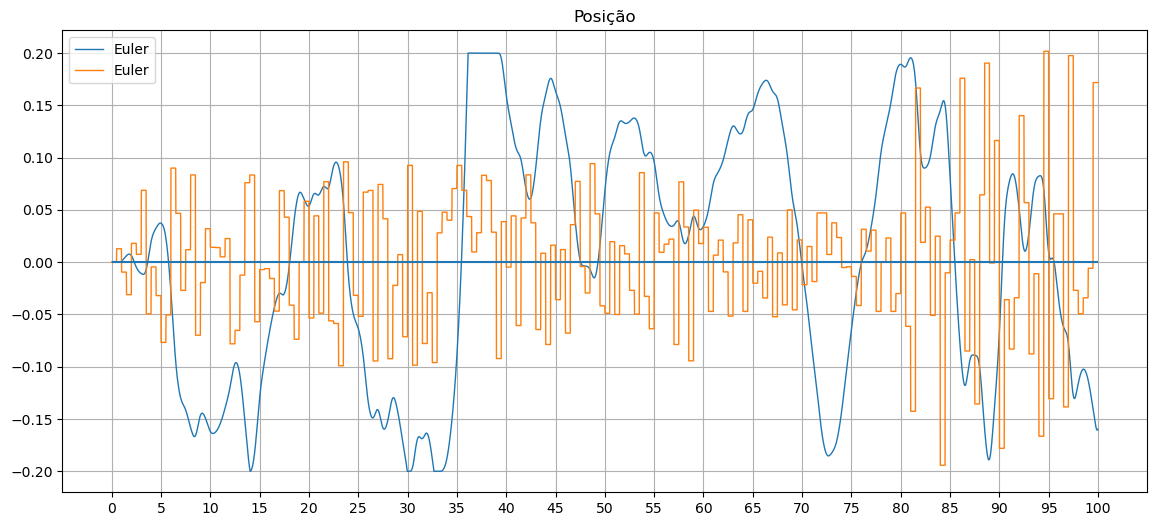

In [122]:
u = uVal.copy();du = np.zeros(t.shape);d2u = np.zeros(t.shape)

du[1:] = (u[1:] - u[:-1]) / dt;d2u[2:] = (du[2:] - du[1:-1]) / dt

s = np.zeros(t.shape);ds = np.zeros(t.shape);d2s = np.zeros(t.shape)

for i in range(1, t.shape[0]):
    um = (u[i-1] + u[i]) / 2
    dum = (um - u[i-1]) / dt
    k1 = m * s[i-1] * (du[i-1]**2) / a + m * g * np.sin(u[i-1]) / a
    k2 = m * (s[i-1] + (dt/2) * k1) * (dum**2) / a + m * g * np.sin(um) / a
    k3 = m * (s[i-1] + (dt/2) * k2) * (dum**2) / a + m * g * np.sin(um) / a
    k4 = m * (s[i-1] + dt * k3) * (du[i]**2) / a + m * g * np.sin(u[i]) / a

    ds[i] = ds[i-1] + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
    s[i] = np.clip(s[i-1] + ds[i] * dt, -0.2, 0.20)
    if np.abs(s[i]) >= 0.2:
        ds[i] = 0

begin = int(0 * 1e+2)
end = int(100 * 1e+2)

plt.figure(figsize=(14, 6))
plt.title("Posição")
plt.plot(t[begin:end], s[begin:end], linewidth=1, label="Euler")
plt.plot(t[begin:end], stairsVal[begin:end] * 3, linewidth=1, label="Euler")
#plt.plot(t[:p], ds[:p], linewidth=1, label="Euler")
plt.hlines(0, begin // 100, end // 100)
plt.xticks(np.arange(begin // 100, end // 100 + 1, 5))
plt.legend();plt.grid();plt.show()

In [124]:
data = np.vstack((u[::1], s[::1], ds[::1], t[::1])).T
np.savetxt("data/ballBeamSaturadoVal.csv", data, delimiter=",", fmt="%.6f", header="input,output,derivada,time", comments="")